# Project 1 by Kevin Andersson and Simon Jacobsson.

In [3]:
import numpy as np
import pandas as pd # for nice tables
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner # for corner plots
from scipy import stats
from scipy.optimize import minimize
from emcee import EnsembleSampler as ensembleSampler # for mcmc
from math import exp,factorial

In [6]:
### load experiment data ###
datafile = 'Data_project1.dat'
X = np.loadtxt(datafile, unpack=True)
x_data = X[0]
y_data = X[1]
sigmas = X[2]

### define pdf:s ###
def log_flat_prior(theta):
    return 0.

def log_gauss_prior(theta):
    width = 5.
    return -((theta**2) / (2 * width**2)).sum() - (len(theta))/2 * np.log(2 * np.pi * width**2)

def log_likelihood(theta):
    """
    Returns the log of the probability density of x_data & y_data being observed from
    a linear model y = theta[0] * x**0 + theta[1] * x**1 + ... + error where error is
    a random variable with a normal distribution centered at 0 with variance sigma**2
    """
    X_d = np.array([x_data**i for i in range(0, len(theta))]).T # design matrix    
    y_pred = X_d.dot(theta)
    summ = (np.log(2 * np.pi * sigmas**2) + (y_data - y_pred)**2 / sigmas**2).sum()
    return -(1/2) * summ

def log_posterior_flat_prior(theta):
    return log_flat_prior(theta) + log_likelihood(theta)

def log_posterior_gauss_prior(theta):
    return log_gauss_prior(theta) + log_likelihood(theta)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [2]:
x_data

NameError: name 'x_data' is not defined

# We now want to reproduce the corner plot

In [3]:
### define MCMC sampler ###
def my_sampling(dim, log_posterior, nbr_walkers = 32, nbr_warmup=100, nbr_samples=10000):
    """
    Returns sample chain from MCMC given dimension dim of problem and a logarithmic pdf
    log_posterior.
    """
    initial_positions = 1 * np.random.rand(nbr_walkers, dim)
    sampler = ensembleSampler(nbr_walkers, dim, log_posterior)
    
    pos, tr, pr = sampler.run_mcmc(initial_positions, nbr_warmup)
    sampler.reset()
    sampler.run_mcmc(pos, nbr_samples);
        
    return sampler.chain    

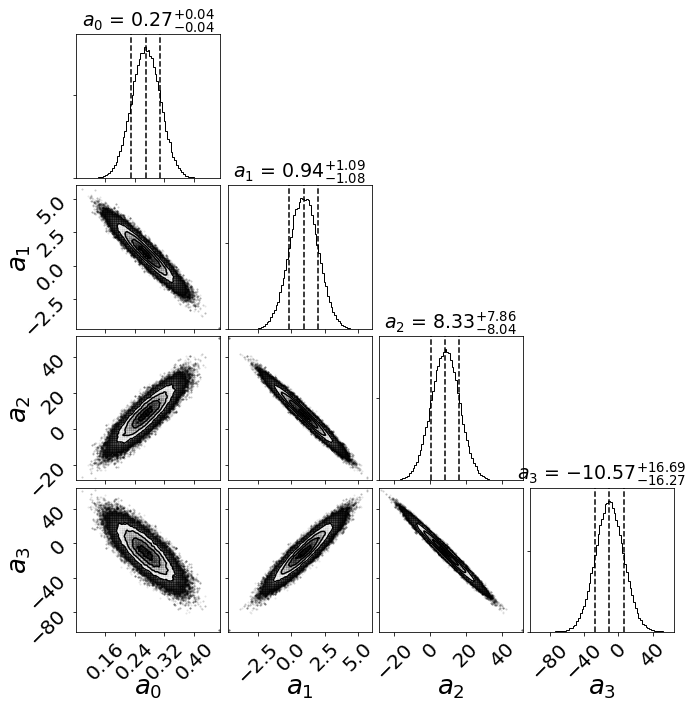

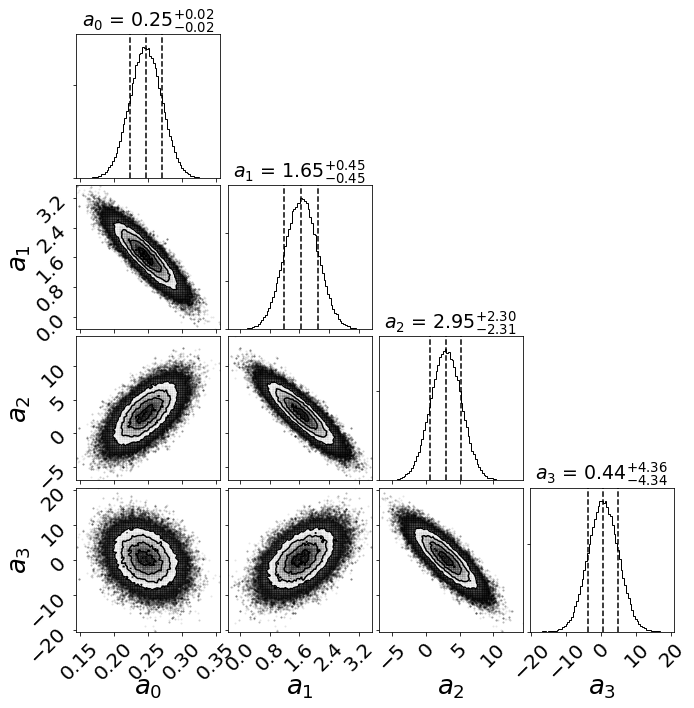

In [4]:
nbr_bins = 81
walkers = 32
nbr_parameters = 4

log_posteriors = [log_posterior_flat_prior, log_posterior_gauss_prior]
filenames = ['fig1_flat_prior.pdf', 'fig1_gauss_prior.pdf']
for log_posterior, filename in zip(log_posteriors, filenames): # loop over two cases: flat & gausian prior
    ### run sampler ###
    samples = my_sampling(nbr_parameters, log_posterior, nbr_walkers=walkers)

    ### append the chains from each walker ###
    total_samples = samples[0,:] # initiate
    for i in range(1,samples.shape[0]):
        total_samples = np.concatenate((total_samples, samples[i,:]), axis=0)

    ### make histogram corner plot ###
    mpl.rcParams.update({'font.size': 26})
    mpl.rc('xtick', labelsize=20)
    mpl.rc('ytick', labelsize=20) 
    latex_labels = [r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"];
    fig = corner.corner(total_samples,quantiles=[0.16, 0.5, 0.84], bins = nbr_bins,
                           show_titles=True, title_kwargs={"fontsize": 19}, labels=latex_labels)
    fig.savefig(filename)
    
plt.show()

# We now want to reproduce the polynomial fits

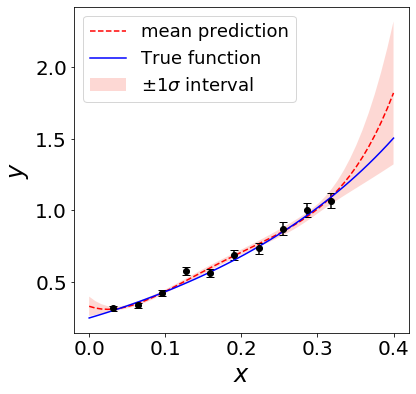

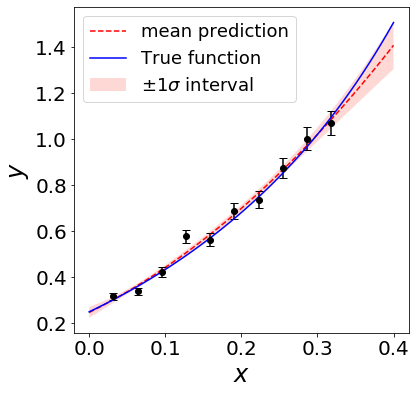

In [5]:
nbr_bins = 81
walkers = 32
nbr_parameters = 5

t = np.linspace(0,0.4)
true_y = lambda x: (1/2+np.tan(np.pi*x/2))**2 

def predict_y(theta, x):
    """
    Returns a predicted y value given parameters theta & x
    """
    y_pred = 0 # initiate
    for i in range(len(theta)):
        y_pred += theta[i] * x**i
    return y_pred

log_posteriors = [log_posterior_flat_prior, log_posterior_gauss_prior]
filenames = ['fig3.pdf', 'fig4.pdf']
for log_posterior, filename in zip(log_posteriors, filenames): #loop over two cases: flat & gaussian prior
    ### run sampler ###
    samples = my_sampling(nbr_parameters, log_posterior, nbr_walkers=walkers)

    ### append the chains from each walker ###
    total_samples = samples[0,:] # initiate
    for i in range(1,samples.shape[0]):
        total_samples = np.concatenate((total_samples, samples[i,:]), axis=0)

    ### fit curve ###
    y = np.zeros((len(total_samples[:,0]),len(t)))
    for i in range(len(total_samples[:,0])):
        y[i,:] = predict_y(total_samples[i,:],t)

    y_mean = y.mean(axis = 0)
    y_variance = np.sqrt(y.var(axis = 0))

    ### plot fitted curve ###
    fig, ax = plt.subplots(figsize = (6,6))
    ax.plot(t,y_mean,"--", color='red', label="mean prediction")
    ax.errorbar(x_data, y_data, sigmas, fmt='o', color='black', capsize=4,)
    ax.fill_between(t, y_mean - y_variance, y_mean + y_variance, facecolor="salmon", alpha=0.3, label=r'$\pm 1 \sigma$ interval') # 68% DOB interval
    
    ### plot true curve ###
    ax.plot(t, true_y(t), label="True function", color='blue')
    ax.set_xlabel(r'$x$', fontsize=24)
    ax.set_ylabel(r'$y$', fontsize=24)
    ax.legend(loc=2, prop={'size': 18})
    fig.savefig(filename)
    
plt.show()

# We now want to reproduce the central value estimate table

In [6]:
### BONUS TASK ###

### define pdf:s ###
def log_gauss_prior2(theta, width=5):
    return -((theta**2) / (2 * width**2)) - ((1/2) * np.log(2 * np.pi * width**2))

def log_flat_prior2(theta):
        return 0
    
def log_posterior_flat_prior2(theta):
    return log_flat_prior2(theta) + log_likelihood(theta)

def log_posterior_gauss_prior2(theta):
    return log_gauss_prior2(theta) + log_likelihood(theta)

In [7]:
def generate_data_for_table_iii(log_post, k_max=6):
    """
    Given a logarithmic posterior log_post, for 0<k<k_max, returns mean estimates mu of
    the model parameters, their variances sig, the reduced chi2 measure
    of goodness of fit, & the evidence.
    """
    #initiate some arrays
    mu = np.zeros((k_max+1, k_max+1))
    sig = np.zeros((k_max+1, k_max+1))
    xi2_dof = np.zeros(k_max+1)
    evidence = np.zeros(k_max+1)

    for k in range(0,k_max+1):
        ### Sampling and concatination ###
        samples = my_sampling(k+1, log_post, nbr_warmup=50, nbr_samples=1000, nbr_walkers = 32)
        total_samples = samples[0,:] #initiate
        for i in range(1,samples.shape[0]): # concatenate all walkers
            total_samples = np.concatenate((total_samples, samples[i,:]), axis=0)

        ### evidence and goodness calculation ###
        mu[k, 0:(k+1)] = total_samples.mean(axis=0)
        sig[k, 0:(k+1)] = np.sqrt(total_samples.var(axis=0))
        cov = np.cov(total_samples[:, 0:k+1].T)
        Z_p = 0
        if k != 0:
            Z_p = 2.5 * np.exp(log_post(mu[k,0:k+1])) * np.sqrt((2 * np.pi)**k * np.linalg.det(cov))
        
        evidence[k] = Z_p
        xi2_dof[k] = ((y_data - predict_y(mu[k, 0:k+1], x_data))**2 / sigmas**2).sum() / (len(y_data) - k -1)
    
    return mu, sig, xi2_dof, evidence

In [8]:
### generate data w/ functions above ###
mu_flat_prior, sig_flat_prior, chi2_dof_flat_prior, __ = generate_data_for_table_iii(log_posterior_flat_prior)
mu_gauss_prior, sig_gauss_prior, __, evidence_gauss_prior = generate_data_for_table_iii(log_posterior_gauss_prior)

### generate tables ###
pd.set_option('precision', 2)
k_max = 6

# flat prior table
flat_prior_table = pd.DataFrame(index=['' for _ in range(k_max+1)]) #initiate
flat_prior_table[r'$k$'] = [min(k,2) for k in range(k_max+1)]
flat_prior_table[r'$k_\text{max}$'] = [k for k in range(k_max+1)]
flat_prior_table[r'$\chi^2/\text{dof}$'] = [f'{chi:.1f}' for chi in chi2_dof_flat_prior]
for i, ai in enumerate(['a0', 'a1', 'a2']): # loop over features
    flat_prior_table[ai] = [f'{mu:.2f}' + r'$\pm$' + f'{sig:.2f}' for mu, sig in zip(mu_flat_prior[:,i], sig_flat_prior[:,i])]

# gauss prior table
gauss_prior_table = pd.DataFrame(index=['' for _ in range(k_max+1)]) #initiate
gauss_prior_table['evidence'] = [f'{ev:.0f}' for ev in evidence_gauss_prior]
for i, ai in enumerate(['a0', 'a1', 'a2']): # loop over features
    gauss_prior_table[ai] = [f'{mu:.2f}' + r'$\pm$' + f'{sig:.2f}' for mu, sig in zip(mu_gauss_prior[:,i], sig_gauss_prior[:,i])]

### display & save tables ###
print('for flat prior:')
display(pd.DataFrame(flat_prior_table))
print('for Gauss prior:')
display(pd.DataFrame(gauss_prior_table))

combined_table = pd.concat((flat_prior_table, gauss_prior_table), axis=1)
file = open('combined_table.tex','w')
file.write(combined_table.to_latex())
file.close()

for flat prior:


,$k$,$k_\text{max}$,$\chi^2/\text{dof}$,a0,a1,a2
,0,0,66.6,0.48$\pm$0.01,0.00$\pm$0.00,0.00$\pm$0.00
,1,1,2.2,0.20$\pm$0.01,2.55$\pm$0.11,0.00$\pm$0.00
,2,2,1.6,0.25$\pm$0.02,1.59$\pm$0.42,3.28$\pm$1.39
,2,3,1.9,0.27$\pm$0.04,0.96$\pm$1.08,8.10$\pm$7.93
,2,4,2.0,0.33$\pm$0.07,-1.55$\pm$2.77,40.36$\pm$33.60
,2,5,1.4,0.51$\pm$0.16,-11.97$\pm$8.38,227.92$\pm$142.65
,2,6,1.9,0.51$\pm$0.27,-11.95$\pm$16.17,230.33$\pm$340.98


for Gauss prior:


,evidence,a0,a1,a2
,0,0.48$\pm$0.01,0.00$\pm$0.00,0.00$\pm$0.00
,622,0.20$\pm$0.01,2.55$\pm$0.11,0.00$\pm$0.00
,3329,0.25$\pm$0.02,1.64$\pm$0.38,3.10$\pm$1.25
,2998,0.25$\pm$0.02,1.65$\pm$0.43,2.91$\pm$2.22
,2805,0.25$\pm$0.02,1.67$\pm$0.47,2.90$\pm$2.38
,2630,0.25$\pm$0.02,1.68$\pm$0.46,2.84$\pm$2.33
,2765,0.25$\pm$0.02,1.66$\pm$0.45,2.85$\pm$2.37


# Generating our own data

In [9]:
### redefine some functions ###
def log_likelihood(theta, data_x, data_y, data_sigmas):
    """
    Returns the log of the probability density of x_data & y_data being observed from
    a linear model y = theta[0] * x**0 + theta[1] * x**1 + ... + error where error is
    a random variable with a normal distribution centered at 0 with variance sigma**2
    """
    X_d = np.array([data_x**i for i in range(0,len(theta))]).T # design matrix    
    y_pred = X_d.dot(theta)
    sum = (np.log(2 * np.pi * data_sigmas**2) + (data_y - y_pred)**2 / data_sigmas**2).sum()
    return -(1/2) * sum

def log_posterior_flat_prior(theta, x_data, y_data, sigmas):
    return log_flat_prior(theta) + log_likelihood(theta,x_data,y_data,sigmas)

def log_posterior_gauss_prior(theta, x_data, y_data, sigmas):
    return log_gauss_prior(theta) + log_likelihood(theta,x_data,y_data,sigmas)

### redefine MCMC sampler ###
def my_sampling(dim, log_posterior, nbr_walkers = 32, nbr_warmup=100, nbr_samples=10000, x_data=x_data, y_data= y_data,sigmas=sigmas):
    """
    Returns sample chain from MCMC given dimension dim of problem and a logarithmic pdf
    log_posterior.
    """
    initial_positions = 1*np.random.rand(nbr_walkers, dim)
    sampler = ensembleSampler(nbr_walkers, dim, log_posterior, args = (x_data,y_data,sigmas))
    
    pos, tr, pr = sampler.run_mcmc(initial_positions, nbr_warmup)
    sampler.reset()
    sampler.run_mcmc(pos, nbr_samples);
        
    return sampler.chain    

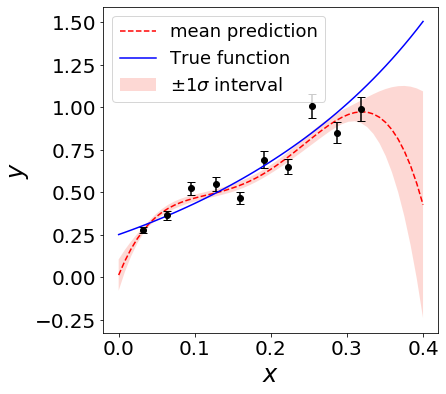

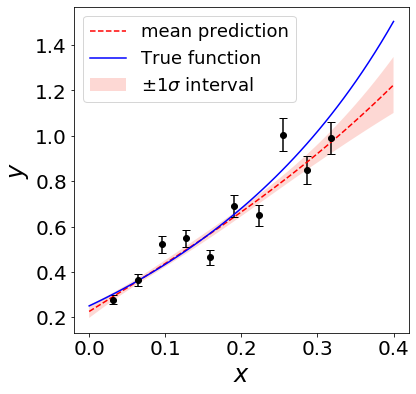

In [10]:
### generate some new y-data w/ bimodal error ###
new_y_data = 0. * x_data # initiate
percent = 0.05 # error percent
for j in range(len(x_data)):
    r = np.random.rand()
    if r < 0.5:
        new_y_data[j] = true_y(x_data[j]) * (1 + 2 * percent + percent * np.random.randn(1))
    else:
        new_y_data[j] = true_y(x_data[j]) * (1 - 2 * percent - percent * np.random.randn(1))
new_sigmas = new_y_data * percent * np.sqrt(2)

log_posteriors = [log_posterior_flat_prior, log_posterior_gauss_prior]
filenames = ['fig3.pdf', 'fig4.pdf']
for log_posterior, filename in zip(log_posteriors, filenames): #loop over two cases: flat & gaussian prior
    ### run sampler ###
    samples = my_sampling(nbr_parameters, log_posterior, nbr_walkers=walkers, y_data=new_y_data, sigmas=new_sigmas)

    ### append the chains from each walker ###
    total_samples = samples[0,:] # initiate
    for i in range(1,samples.shape[0]):
        total_samples = np.concatenate((total_samples, samples[i,:]), axis=0)

    ### fit curve ###
    y = np.zeros((len(total_samples[:,0]),len(t)))
    for i in range(len(total_samples[:,0])):
        y[i,:] = predict_y(total_samples[i,:],t)

    y_mean = y.mean(axis = 0)
    y_variance = np.sqrt(y.var(axis = 0))

    ### plot fitted curve ###
    fig, ax = plt.subplots(figsize = (6,6))
    ax.plot(t,y_mean,"--", color='red', label="mean prediction")
    ax.errorbar(x_data, new_y_data, new_sigmas, fmt='o', color='black', capsize=4,)
    ax.fill_between(t, y_mean - y_variance, y_mean + y_variance, facecolor="salmon", alpha=0.3, label=r'$\pm 1 \sigma$ interval') # 68% DOB interval
    
    ### plot true curve ###
    ax.plot(t, true_y(t), label="True function", color='blue')
    ax.set_xlabel(r'$x$', fontsize=24)
    ax.set_ylabel(r'$y$', fontsize=24)
    ax.legend(loc=2, prop={'size': 18})
    fig.savefig(filename)
plt.show()